In [27]:
%matplotlib inline
import re
import string
import gensim
import artm
import matplotlib.pyplot as plt
from collections import Counter
from nltk.corpus import stopwords
from pymorphy2 import MorphAnalyzer
morph = MorphAnalyzer()

In [2]:
texts = open('/Users/macbookpro/Downloads/habr.txt').read().splitlines()

In [3]:
stops = set(stopwords.words('russian')) | {'gt',}
def remove_tags(text):
    return re.sub(r'<[^>]+>', '', text)


def opt_normalize(texts, top=None):
    uniq = Counter()
    for text in texts:
        uniq.update(text)
    
    norm_uniq = {word:morph.parse(word.replace(':', ''))[0].normal_form for word, _ in uniq.most_common(top)}
    
    norm_texts = []
    for text in texts:
        
        norm_words = [norm_uniq.get(word) for word in text]
        norm_words = [word for word in norm_words if word and word not in stops]
        norm_texts.append(norm_words)
        
    return norm_texts

def tokenize(text):
    words = [word.strip(string.punctuation) for word in text.split()]
    words = [word for word in words if word]
    
    return words

In [4]:
texts = opt_normalize([tokenize(remove_tags(text.lower())) for text in texts], 30000)

In [5]:
ph = gensim.models.Phrases(texts, scoring='npmi', threshold=0.3, 
                            common_terms=set(stopwords.words('russian'))) 

In [6]:
p = gensim.models.phrases.Phraser(ph)

In [7]:
ngrammed = p[texts]

In [8]:
f = open('texts.vw', 'w')

In [9]:
for i, text in enumerate(ngrammed):
    c = Counter(text)
    doc = 'doc_'+ str(i) + ' '
    vw_text = ' '.join([x+':'+str(c[x]) for x in c])
    
    f.write(doc + vw_text  + '\n')
f.close()

In [10]:
batch_vectorizer = artm.BatchVectorizer(data_path='texts.vw',
                                        data_format='vowpal_wabbit',
                                        target_folder='batches',
                                       batch_size=1000)

In [11]:
dictionary = artm.Dictionary()

In [33]:
dictionary.gather(data_path='batches')
dictionary.filter(class_id='@default_class',
                  min_df=10, max_df=2000)

artm.Dictionary(name=d0ea2d8c-7965-47c2-a23f-1812d1a0fa7b, num_entries=14420)

In [34]:
dictionary.save_text('dict.txt')

In [46]:
model_artm = artm.ARTM(topic_names=['topic_{}'.format(i) for i in range(200)],
                       
                       regularizers=[
                           artm.DecorrelatorPhiRegularizer(
                                            name='Decorr', tau=0.25, 
                                            class_ids=['@default_class'],
                                            topic_names=['topic_{}'.format(i) for i in range(0, 200)]),
                           
                           artm.SmoothSparsePhiRegularizer(
                                            name='SmoothPhi_1', 
                                            class_ids=['@default_class'],
                                            tau=0.15, 
                                            topic_names=['topic_{}'.format(i) for i in range(0, 200)])
                                    ]
                        )

In [47]:
model_artm.initialize(dictionary=dictionary, )

In [48]:
def print_measures(model_artm):
    print('Sparsity Phi: {0:.3f} ARTM)'.format(
        model_artm.score_tracker['SparsityPhiScore'].last_value)
)
    print('Sparsity Theta: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['SparsityThetaScore'].last_value))

    print('Kernel contrast: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['TopicKernelScore'].last_average_contrast))

    print('Kernel purity: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['TopicKernelScore'].last_average_purity))

    print('Perplexity: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['PerplexityScore'].last_value)
)
    plt.plot(range(model_artm.num_phi_updates), model_artm.score_tracker['PerplexityScore'].value, 'r--', linewidth=2)
    plt.xlabel('Iterations count')
    plt.ylabel(' ARTM perp. (red)')
    plt.grid(True)
    plt.show()
    

In [49]:
model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                                    dictionary=dictionary))
model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore')) 
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore')) 
model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.1))
model_artm.scores.add(artm.TopTokensScore(class_id='@default_class', name='TopTokensScore_1', num_tokens=10))

In [50]:
model_artm.num_document_passes = 10
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=4)

Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.003 (ARTM)
Kernel contrast: 0.139 (ARTM)
Kernel purity: 0.034 (ARTM)
Perplexity: 627.371 (ARTM)


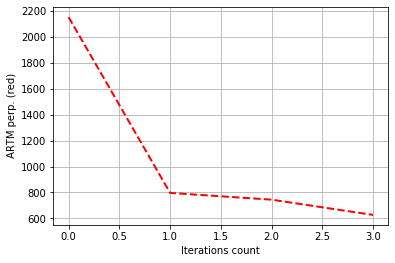

In [51]:
print_measures(model_artm)

In [52]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.15, 
                                                            topic_names=['topic_{}'.format(i) for i in range(1, 200)],
                                                            ))
model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.15, 
                                                              topic_names=['topic_{}'.format(i) for i in range(1, 200)]))

In [53]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=1)

In [54]:
phi_tau = model_artm.regularizers['SparsePhi'].tau
theta_tau = model_artm.regularizers['SparseTheta'].tau

for i in range(10):
    model_artm.regularizers['SparsePhi'].tau = (phi_tau + (phi_tau*0.5))
    model_artm.regularizers['SparseTheta'].tau = (theta_tau + (theta_tau*0.1))
    
    model_artm.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=1)

Sparsity Phi: 0.855 ARTM)
Sparsity Theta: 0.838 (ARTM)
Kernel contrast: 0.217 (ARTM)
Kernel purity: 0.230 (ARTM)
Perplexity: 334.302 (ARTM)


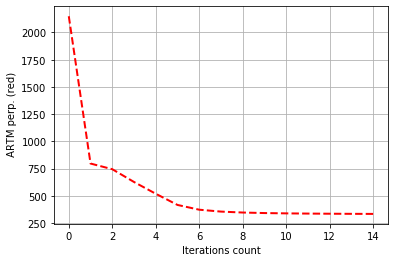

In [55]:
print_measures(model_artm)

In [56]:
for topic_name in model_artm.topic_names[:50]:
    print(topic_name + ': ')
    try:
        for x in model_artm.score_tracker['TopTokensScore_1'].last_tokens[topic_name]:
            print(x)
        print('---------')
    
    except KeyError:
        continue

topic_0: 
хранилище
кластер
вм
массив
storage
хост
репликация
хранение
объект
узел
---------
topic_1: 
ноутбук
lenovo
устройство
рубль
клавиатура
память
стоить
экран
процессор
цена
---------
topic_2: 
курс
лекция
студент
материал
человек
обучение
тема
вопрос
занятие
знание
---------
topic_3: 
закон
информация
являться
право
организация
результат
документ
открытый
государственный
рф
---------
topic_4: 
инструкция
процессор
стек
код
память
регистр
архитектура
компилятор
программа
ассемблер
---------
topic_5: 
дрон
робот
металл
машина
мотор
дронов
плёнка
материал
камера
расстояние
---------
topic_6: 
система
функционал
cms
продукт
сайт
дизайн
решение
программный_продукт
любой
разный
---------
topic_7: 
задача
заказчик
проект
команда
разработка
разработчик
тз
scrum
исполнитель
результат
---------
topic_8: 
конференция
доклад
участник
мероприятие
рассказать
тема
встреча
спикер
участие
день
---------
topic_9: 
•
являться
почему
тип
некоторый
иметься
необходимый
поскольку
использование
язык
-

In [57]:
model_artm = artm.ARTM(topic_names=['topic_{}'.format(i) for i in range(300)],
                       
                       regularizers=[
                           artm.DecorrelatorPhiRegularizer(
                                            name='Decorr', tau=0.3, 
                                            class_ids=['@default_class'],
                                            topic_names=['topic_{}'.format(i) for i in range(0, 300)]),
                           
                           artm.SmoothSparsePhiRegularizer(
                                            name='SmoothPhi_1', 
                                            class_ids=['@default_class'],
                                            tau=0.2, 
                                            topic_names=['topic_{}'.format(i) for i in range(0, 300)])
                                    ]
                        )

In [58]:
model_artm.initialize(dictionary=dictionary, )

In [59]:
model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                                    dictionary=dictionary))
model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore')) 
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore')) 
model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.1))
model_artm.scores.add(artm.TopTokensScore(class_id='@default_class', name='TopTokensScore_1', num_tokens=10))

In [60]:
model_artm.num_document_passes = 10
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=4)

Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.003 (ARTM)
Kernel contrast: 0.086 (ARTM)
Kernel purity: 0.020 (ARTM)
Perplexity: 667.692 (ARTM)


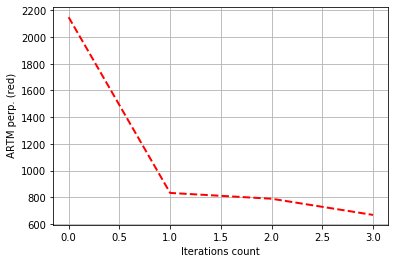

In [61]:
print_measures(model_artm)

In [62]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.2, 
                                                            topic_names=['topic_{}'.format(i) for i in range(1, 300)],
                                                            ))
model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.2, 
                                                              topic_names=['topic_{}'.format(i) for i in range(1, 300)]))

In [63]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=1)

In [64]:
phi_tau = model_artm.regularizers['SparsePhi'].tau
theta_tau = model_artm.regularizers['SparseTheta'].tau

for i in range(10):
    model_artm.regularizers['SparsePhi'].tau = (phi_tau + (phi_tau*0.5))
    model_artm.regularizers['SparseTheta'].tau = (theta_tau + (theta_tau*0.1))
    
    model_artm.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=1)

Sparsity Phi: 0.892 ARTM)
Sparsity Theta: 0.894 (ARTM)
Kernel contrast: 0.210 (ARTM)
Kernel purity: 0.214 (ARTM)
Perplexity: 304.778 (ARTM)


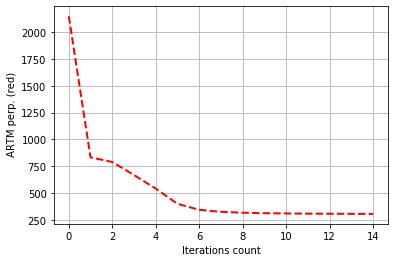

In [65]:
print_measures(model_artm)

In [66]:
for topic_name in model_artm.topic_names[:50]:
    print(topic_name + ': ')
    try:
        for x in model_artm.score_tracker['TopTokensScore_1'].last_tokens[topic_name]:
            print(x)
        print('---------')
    
    except KeyError:
        continue

topic_0: 
new
num
блок
true
light
var_new
xmlhttprequest
длина
0
твой
---------
topic_1: 
ноутбук
lenovo
устройство
рубль
стоить
цена
экран
intel
процессор
память
---------
topic_2: 
курс
лекция
студент
обучение
материал
школа
знание
университет
занятие
человек
---------
topic_3: 
право
являться
суд
организация
закон
распространение
открытый
результат
использование
дело
---------
topic_4: 
процессор
инструкция
архитектура
регистр
ассемблер
память
компилятор
код
результат
intel
---------
topic_5: 
дрон
металл
материал
изделие
плёнка
металлический
технология
производство
использоваться
алюминий
---------
topic_6: 
функционал
система
программный_продукт
cms
1с
решение
любой
продукт
сайт
очень
---------
topic_7: 
заказчик
задача
проект
разработка
исполнитель
процесс
документация
срок
команда
разработчик
---------
topic_8: 
доклад
конференция
тема
выступление
видео
разработчик
—_это
спикер
рассказать
говорить
---------
topic_9: 
•
почему
система
энергия
двигатель
•_•
являться
иметься
некото

In [67]:
model_artm = artm.ARTM(topic_names=['topic_{}'.format(i) for i in range(150)],
                       
                       regularizers=[
                           artm.DecorrelatorPhiRegularizer(
                                            name='Decorr', tau=0.6, 
                                            class_ids=['@default_class'],
                                            topic_names=['topic_{}'.format(i) for i in range(0, 150)]),
                           
                           artm.SmoothSparsePhiRegularizer(
                                            name='SmoothPhi_1', 
                                            class_ids=['@default_class'],
                                            tau=0.44, 
                                            topic_names=['topic_{}'.format(i) for i in range(0, 150)])
                                    ]
                        )

In [68]:
model_artm.initialize(dictionary=dictionary, )

In [69]:
model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                                    dictionary=dictionary))
model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore')) 
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore')) 
model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.1))
model_artm.scores.add(artm.TopTokensScore(class_id='@default_class', name='TopTokensScore_1', num_tokens=10))

In [70]:
model_artm.num_document_passes = 10
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=4)

Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.002 (ARTM)
Kernel contrast: 0.109 (ARTM)
Kernel purity: 0.029 (ARTM)
Perplexity: 698.408 (ARTM)


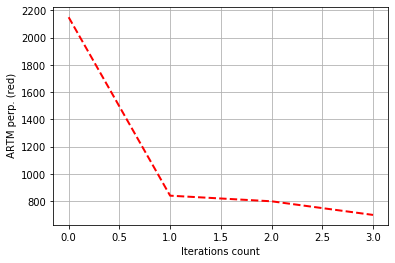

In [71]:
print_measures(model_artm)

In [72]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.35, 
                                                            topic_names=['topic_{}'.format(i) for i in range(1, 150)],
                                                            ))
model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.5, 
                                                              topic_names=['topic_{}'.format(i) for i in range(1, 150)]))

In [73]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=1)

In [74]:
phi_tau = model_artm.regularizers['SparsePhi'].tau
theta_tau = model_artm.regularizers['SparseTheta'].tau

for i in range(10):
    model_artm.regularizers['SparsePhi'].tau = (phi_tau + (phi_tau*0.5))
    model_artm.regularizers['SparseTheta'].tau = (theta_tau + (theta_tau*0.1))
    
    model_artm.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=1)

Sparsity Phi: 0.848 ARTM)
Sparsity Theta: 0.877 (ARTM)
Kernel contrast: 0.213 (ARTM)
Kernel purity: 0.273 (ARTM)
Perplexity: 371.961 (ARTM)


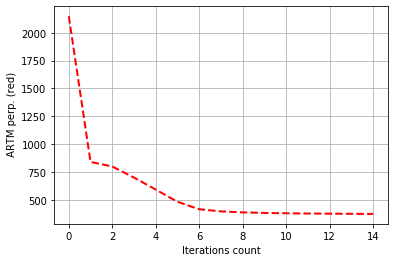

In [75]:
print_measures(model_artm)

In [84]:
topics = []
for topic_name in model_artm.topic_names[:50]:
    try:
        for x in model_artm.score_tracker['TopTokensScore_1'].last_tokens[topic_name]:
            topics.append(x)
        topics.append('---------')
    
    except KeyError:
        continue

In [85]:
topics

['light',
 'new',
 'sample',
 'num',
 'if',
 'головной',
 'else',
 'true',
 'фио',
 'блок',
 '---------',
 'ноутбук',
 'компьютер',
 'устройство',
 'lenovo',
 'жёсткий_диск',
 'рубль',
 'компания',
 'стоить',
 'доллар',
 'ibm',
 '---------',
 'курс',
 'лекция',
 'студент',
 'школа',
 'обучение',
 'материал',
 'занятие',
 'человек',
 'программа',
 'университет',
 '---------',
 'закон',
 'право',
 'информация',
 'суд',
 'являться',
 'дело',
 'использование',
 'открытый',
 'организация',
 'вопрос',
 '---------',
 'процессор',
 'инструкция',
 'память',
 'регистр',
 'код',
 'архитектура',
 'ядро',
 'стек',
 'программа',
 'компилятор',
 '---------',
 'камера',
 'регистратор',
 'устройство',
 '–',
 'модель',
 'видео',
 'производитель',
 'запись',
 'случай',
 'аппарат',
 '---------',
 'пользователь',
 'ваш',
 'интерфейс',
 'дизайн',
 'продукт',
 'иконка',
 'окно',
 'кнопка',
 'экран',
 'текст',
 '---------',
 'задача',
 'заказчик',
 'проект',
 'разработчик',
 'разработка',
 'код',
 'сервис',
 

In [91]:
print(topics[11:21], '\n\n', topics[23:32], '\n\n', topics[45:54])

['ноутбук', 'компьютер', 'устройство', 'lenovo', 'жёсткий_диск', 'рубль', 'компания', 'стоить', 'доллар', 'ibm'] 

 ['лекция', 'студент', 'школа', 'обучение', 'материал', 'занятие', 'человек', 'программа', 'университет'] 

 ['инструкция', 'память', 'регистр', 'код', 'архитектура', 'ядро', 'стек', 'программа', 'компилятор']


График обучения третьей, наиболее удачной на мой взгляд модели отрисован выше.

Количество тем я настроила на 150; использовала фи- и тета-регуляризаторы с tau=-0.35 и tau=-0.5 соответственно; после первого прохода значения tau 